In [25]:
import torch
from pathlib import Path
import torch
import torchvision
from torch import nn
from torchvision import transforms


In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
#Transforms for images
transforms = torchvision.transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

])

In [29]:
#Loading CIFAR10 Dataset
import torchvision
from torch.utils.data import DataLoader
import os

data_path = Path('data/')

train_dir = data_path / "train"
# test_dir = data_path / "test"

train_data = torchvision.datasets.CIFAR10(root = train_dir , train=True, download=True, transform=transforms)
# test_data = torchvision.datasets.CIFAR10(root = test_dir, train=False, download=True)

train_dataloader = DataLoader(dataset=train_data, num_workers=os.cpu_count(), batch_size=128, shuffle=True)
# test_dataloader = DataLoader(dataset=test_data, num_workers=os.cpu_count(), batch_size=128, shuffle=True)


100%|██████████| 170498071/170498071 [00:33<00:00, 5017851.56it/s]


Extracting data/train/cifar-10-python.tar.gz to data/train


100%|██████████| 170498071/170498071 [00:42<00:00, 4039871.24it/s]


Extracting data/test/cifar-10-python.tar.gz to data/test


In [ ]:
#Loading the CelebA dataset
data_path = Path('data/img_align_celeba')
dataset = torchvision.utils.dataset.ImageFolder(root=data_path,
                           transform=transforms.Compose([
                               transforms.Resize(64,64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
#Creating a dataloader
dataloader = DataLoader(dataset=dataset, num_workers=os.cpu_count(), batch_size=128, shuffle=True)

In [30]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  #mean = 0, std = 0.02


In [43]:
class Generator(nn.Module):
    def __init__(
        self,
        latent_vector_size = 100,
        no_of_channels = 3,
        kernel_size = (4,4),
        stride: int = 2,
        number_of_feature_maps: int = 64,
        padding: int = 1,
    ):

        super().__init__()

        # self.wi = weight_initialization()
        self.main = nn.Sequential(



            nn.ConvTranspose2d(latent_vector_size, number_of_feature_maps * 16 , kernel_size=kernel_size, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(number_of_feature_maps * 16),
            nn.ReLU(),

            #shape = (...,1024, 4, 4)
            nn.ConvTranspose2d(number_of_feature_maps * 16, number_of_feature_maps * 8 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(number_of_feature_maps * 8),
            nn.ReLU(),

            #shape = (..., 512, 8, 8)
            nn.ConvTranspose2d(number_of_feature_maps * 8, number_of_feature_maps * 4 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(number_of_feature_maps * 4),

             #shape = (..., 256, 16, 16)
            nn.ConvTranspose2d(number_of_feature_maps * 4, number_of_feature_maps * 2 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(number_of_feature_maps * 2),

             #shape = (..., 128, 32, 32)
            nn.ConvTranspose2d(number_of_feature_maps * 2, no_of_channels , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.Tanh()
            #shape = (..., 3, 64, 64)
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [44]:
#Intializing the Generator instance
generator = Generator().to(device)

#Applying the weights transformation
generator.apply(weights_init)

#Printing the structure
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


In [45]:
from torchinfo import summary


summary(model=generator,
        input_size=(128, 100, 1, 1),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                    [128, 100, 1, 1]     [128, 3, 64, 64]     --                   True
├─Sequential (main)                      [128, 100, 1, 1]     [128, 3, 64, 64]     --                   True
│    └─ConvTranspose2d (0)               [128, 100, 1, 1]     [128, 1024, 4, 4]    1,638,400            True
│    └─BatchNorm2d (1)                   [128, 1024, 4, 4]    [128, 1024, 4, 4]    2,048                True
│    └─ReLU (2)                          [128, 1024, 4, 4]    [128, 1024, 4, 4]    --                   --
│    └─ConvTranspose2d (3)               [128, 1024, 4, 4]    [128, 512, 8, 8]     8,388,608            True
│    └─BatchNorm2d (4)                   [128, 512, 8, 8]     [128, 512, 8, 8]     1,024                True
│    └─ReLU (5)                          [128, 512, 8, 8]     [128, 512, 8, 8]     --                   --
│    └─ConvTranspo

In [46]:
class Discriminator(nn.Module):
    def __init__(
        self,
        no_of_channels = 3,
        kernel_size = (4,4),
        stride: int = 2,
        number_of_feature_maps: int = 64,
        padding: int = 1,
        lr_slope=0.2,
    ):

        super().__init__()

         #shape = (..., 3, 64, 64)
        self.main = nn.Sequential(
            nn.Conv2d(no_of_channels, number_of_feature_maps * 2 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            # nn.BatchNorm2d(number_of_feature_maps * 8),
            nn.LeakyReLU(negative_slope=lr_slope),

                #shape = (...,1024, 32, 32)
            nn.Conv2d(number_of_feature_maps * 2, number_of_feature_maps * 4 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(number_of_feature_maps * 4),
            nn.LeakyReLU(negative_slope=lr_slope),

                #shape = (..., 512, 16, 16)
            nn.Conv2d(number_of_feature_maps * 4, number_of_feature_maps * 8 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(number_of_feature_maps * 8),
            nn.LeakyReLU(negative_slope=lr_slope),

                #shape = (..., 256, 8, 8)
            nn.Conv2d(number_of_feature_maps * 8, number_of_feature_maps * 16 , kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(number_of_feature_maps * 16),
            nn.LeakyReLU(negative_slope=lr_slope),
            #  shape = (..., 128, 4, 4)

            nn.Conv2d(number_of_feature_maps * 16, 1 , kernel_size=kernel_size, stride=4, padding=padding, bias=False),
            #shape = (...,1,1)
            nn.Flatten(),
            nn.Sigmoid(),
         )

    def forward(self, x):
        return self.main(x)

In [47]:
#Intializing the Discriminator instance
discriminator = Discriminator().to(device)
#Apply the wieght intilization function layer by layer
discriminator = discriminator.apply(weights_init)
#Printing the structure
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1), bias=False)
    (12): Flatten(start_dim=1, end_

In [48]:
from torchinfo import summary


summary(model=discriminator,
        input_size=(128, 3, 64, 64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Discriminator (Discriminator)            [128, 3, 64, 64]     [128, 1]             --                   True
├─Sequential (main)                      [128, 3, 64, 64]     [128, 1]             --                   True
│    └─Conv2d (0)                        [128, 3, 64, 64]     [128, 128, 32, 32]   6,144                True
│    └─LeakyReLU (1)                     [128, 128, 32, 32]   [128, 128, 32, 32]   --                   --
│    └─Conv2d (2)                        [128, 128, 32, 32]   [128, 256, 16, 16]   524,288              True
│    └─BatchNorm2d (3)                   [128, 256, 16, 16]   [128, 256, 16, 16]   512                  True
│    └─LeakyReLU (4)                     [128, 256, 16, 16]   [128, 256, 16, 16]   --                   --
│    └─Conv2d (5)                        [128, 256, 16, 16]   [128, 512, 8, 8]     2,097,152            True
│    └─BatchNorm2d

In [52]:
epochs = 30
beta_1 = 0.5
lr_optimizer = 0.0002
loss_fn = nn.BCELoss()  #BCELoss function

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizerD = torch.optim.Adam(params=discriminator.parameters(), betas=(beta_1, 0.999), lr=lr_optimizer) #For discriminator
optimizerG = torch.optim.Adam(params=generator.parameters(), betas=(beta_1, 0.999), lr=lr_optimizer) #For generator

batch_size = 128
latent_vector_size = 100

real_label = 1
fake_label = 0


loss_g = []
loss_d = []
img_list = []

# Fixed noise for generating the images
fixed_noise = torch.randn((batch_size, latent_vector_size, 1, 1), dtype=torch.float32, device=device)

In [53]:
import shutil
save_images = Path('output_images/')
shutil.rmtree(save_images)
shutil.rmtree(Path('weights/'))
save_images.mkdir()
Path('weights/').mkdir()

In [54]:
#Training loop

generator.train()
discriminator.train()
iters = 0


for epoch in range(epochs):
    for i, (X, _) in enumerate(train_dataloader):

        X = X.to(device)

        #Train the discriminator (with real data)

        ############################
        # (1) Update D network: maximize: log(1 - D(G(z)))
        ###########################

        current_batch_size = X.shape[0]  #Getting the current batch size
        
        real_data = torch.ones((current_batch_size,), device=device, dtype=torch.float32)

        # 1. Forward pass
        y_pred = discriminator(X).view(-1)

        # 2. Calculate  and accumulate loss
        loss_real = loss_fn(y_pred, real_data)


        # 3. Optimizer zero grad
        optimizerD.zero_grad()

        # 4. Loss backward
        loss_real.backward(retain_graph=True)


        #Train the discriminator (with fake data)

        noise = torch.randn((batch_size, latent_vector_size, 1, 1), device=device)
        fake_data = torch.zeros((batch_size,), device=device, dtype=torch.float32)
        noise_generated_by_generator = generator(noise)

        #1. Forward pass
        y_pred = discriminator(noise_generated_by_generator).view(-1)


        # 2. Calculate  and accumulate loss
        loss_fake = loss_fn(y_pred, fake_data)


        # 4. Loss backward
        loss_fake.backward(retain_graph=True)

        # 5. Optimizer step
        optimizerD.step()

        #Accumulating total discriminator loss
        discriminator_combined_loss = loss_real + loss_fake
        loss_d.append(discriminator_combined_loss.item())



        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        labels = torch.ones((batch_size,), device=device, dtype=torch.float32)

        #1. Forward pass
        y_pred = discriminator(noise_generated_by_generator).view(-1)
        # y_pred = torch.argmax(probs, dim=1).type(torch.float32)


        #2. Calculate and accumulate loss
        loss_gen = loss_fn(y_pred,labels)


        # 3. Optimizer zero grad
        optimizerG.zero_grad()

        # 4. Loss backward
        loss_gen.backward()

        # 5. Optimizer step
        optimizerG.step()

        loss_g.append(loss_gen.item())

        if iters % 300 == 0:
          print("Iterations: ", iters, "Epoch: ", epoch, "Generator loss: ", loss_gen.item(), "Discriminator loss: ", discriminator_combined_loss.item())

        #save the output
        if iters % 300 == 0:
          print('saving the output')
          torchvision.utils.save_image(X,'{}/real_images_steps_{}.png'.format(save_images, iters),normalize=True)
          fake = generator(fixed_noise)
          torchvision.utils.save_image(fake,'{}/fake_images_steps_{}.png'.format(save_images, iters),normalize=True)


          # Check pointing for every epoch
          torch.save(generator.state_dict(), 'weights/generator_steps_%d.pth' % (iters))
          torch.save(discriminator.state_dict(), 'weights/discriminator_steps_%d.pth' % (iters))


        iters += 1


Iterations:  0 Epoch:  0 Generator loss:  5.775015354156494 Discriminator loss:  1.3180489540100098
saving the output
Iterations:  300 Epoch:  0 Generator loss:  2.508517026901245 Discriminator loss:  0.9978139400482178
saving the output
Iterations:  600 Epoch:  1 Generator loss:  2.6749417781829834 Discriminator loss:  0.8628716468811035
saving the output
Iterations:  900 Epoch:  2 Generator loss:  0.7185548543930054 Discriminator loss:  1.2825517654418945
saving the output
Iterations:  1200 Epoch:  3 Generator loss:  2.142946720123291 Discriminator loss:  1.0675123929977417
saving the output
Iterations:  1500 Epoch:  3 Generator loss:  3.3442420959472656 Discriminator loss:  0.6606197953224182
saving the output
Iterations:  1800 Epoch:  4 Generator loss:  4.498741149902344 Discriminator loss:  0.2591347396373749
saving the output
Iterations:  2100 Epoch:  5 Generator loss:  2.0226926803588867 Discriminator loss:  0.9655534625053406
saving the output
Iterations:  2400 Epoch:  6 Genera

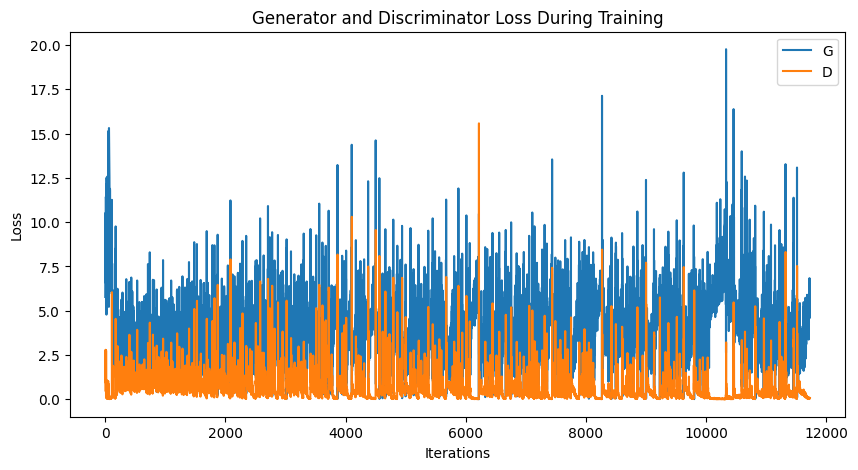

In [55]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_g,label="G")
plt.plot(loss_d,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

